In [1]:
import numpy as np
import pandas as pd
import logging
import networkx as nx
import dowhy
from dowhy import CausalModel
import dowhy.datasets


In [2]:
#convert csv to pandas
path = "./Scraped_Data.csv"
df = pd.read_csv(path)


In [3]:
dfcopy = df.loc[:, ['random_rating','accepted','submitted_arxiv','avg_h_index']]

dfcopy["submitted_arxiv"] = dfcopy["submitted_arxiv"].astype(bool)
dfcopy.loc[dfcopy.accepted == 'a','accepted'] = True
dfcopy.loc[dfcopy.accepted == 'ap','accepted'] = True
dfcopy.loc[dfcopy.accepted == 'r','accepted'] = False
dfcopy.loc[dfcopy.accepted == 'wp','accepted'] = False

In [4]:
dfcopy

,random_rating,accepted,submitted_arxiv,avg_h_index
0,9,True,True,19
1,4,False,False,10
2,6,True,True,20
3,6,False,True,72
4,7,True,True,30
...,...,...,...,...
906,7,False,False,28
907,5,False,False,10
908,5,False,False,35
909,2,False,False,1


In [7]:
# data = dowhy.datasets.linear_dataset(beta=10,
#         num_common_causes=5,
#         num_instruments = 2,
#         num_treatments=1,
#         num_samples=10000,
#         treatment_is_binary=True,
#         outcome_is_binary=False)

In [132]:
# treatment = ["avg_h_index","random_rating"]
# outcome = ["accepted"]
# data["instrument_names"],
# # logging.INFO

In [147]:
data["gml_graph"]


'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[source "Unobserved Confounders" target "v0"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

In [133]:
# #graph in gml format
# graph = 'graph[directed 1node[id "avg_h_index" label "Fame"] node [id "accepted" label "Accept/Reject"] node[id "random_rating" label "Paper Quality"] node[id "submitted_arxiv" label "is_Arxiv"] edge[source "avg_h_index" target "submitted_arxiv"] edge[source "avg_h_index" target "accepted"] edge[source "random_rating" target "submitted_arxiv"] edge[source "random_rating" target "accepted"]]'

In [18]:
#graph in gml format
graph = 'graph[directed 1node[id "avg_h_index" label "avg_h_index"] node [id "accepted" label "accepted"] node[id "random_rating" label "random_rating"] node[id "submitted_arxiv" label "submitted_arxiv"] edge[source "avg_h_index" target "submitted_arxiv"] edge[source "avg_h_index" target "accepted"] edge[source "random_rating" target "submitted_arxiv"] edge[source "random_rating" target "accepted"]]'

In [19]:
print(graph)

graph[directed 1node[id "avg_h_index" label "avg_h_index"] node [id "accepted" label "accepted"] node[id "random_rating" label "random_rating"] node[id "submitted_arxiv" label "submitted_arxiv"] edge[source "avg_h_index" target "submitted_arxiv"] edge[source "avg_h_index" target "accepted"] edge[source "random_rating" target "submitted_arxiv"] edge[source "random_rating" target "accepted"]]


In [20]:
G = nx.readwrite.gml.parse_gml(graph,label = 'id')
list(G.edges)
list(G.nodes)

['avg_h_index', 'accepted', 'random_rating', 'submitted_arxiv']

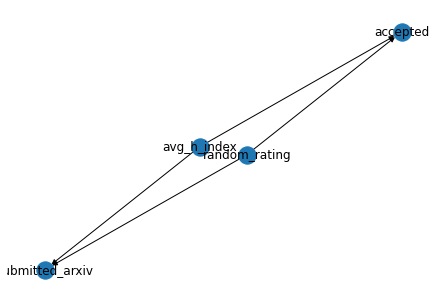

In [21]:
nx.draw(G,with_labels = True)

In [144]:
# type(data["treatment_name"])
# type(['random_rating','avg_h_index'])

In [22]:
model = CausalModel(
    data=dfcopy,
    graph = graph,
    treatment = ['random_rating','avg_h_index'],
    outcome = ['accepted']
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['random_rating', 'avg_h_index'] on outcome ['accepted']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


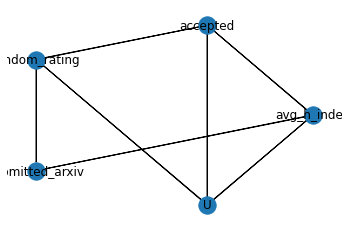

In [23]:
model.view_model()

In [26]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
              d                                     
─────────────────────────────(Expectation(accepted))
d[random_rating  avg_h_index]                       
Estimand assumption 1, Unconfoundedness: If U→{random_rating,avg_h_index} and U→accepted then P(accepted|random_rating,avg_h_index,,U) = P(accepted|random_rating,avg_h_index,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [34]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: accepted~random_rating+avg_h_index


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
              d                                     
─────────────────────────────(Expectation(accepted))
d[random_rating  avg_h_index]                       
Estimand assumption 1, Unconfoundedness: If U→{random_rating,avg_h_index} and U→accepted then P(accepted|random_rating,avg_h_index,,U) = P(accepted|random_rating,avg_h_index,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: accepted~random_rating+avg_h_index
## Estimate
Value: 0.1698790821590082

## Statistical Significance
p-value: <0.001

Causal Estimate is 0.1698790821590082


In [35]:
linear_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: accepted~random_rating+avg_h_index


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
              d                                     
─────────────────────────────(Expectation(accepted))
d[random_rating  avg_h_index]                       
Estimand assumption 1, Unconfoundedness: If U→{random_rating,avg_h_index} and U→accepted then P(accepted|random_rating,avg_h_index,,U) = P(accepted|random_rating,avg_h_index,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: accepted~random_rating+avg_h_index
## Estimate
Value: 0.1698790821590082

## Statistical Significance
p-value: <0.001

Causal Estimate is 0.1698790821590082


In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
import sklearn.ensemble
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["avg_h_index"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: accepted~random_rating+avg_h_index


ValueError: bad input shape (455, 2)

In [30]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: accepted~random_rating+avg_h_index


ValueError: bad input shape (455, 2)